<a href="https://colab.research.google.com/github/RamyaGuru/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_example_AIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model 
5. Using already trained models to make fast predictions

In [1]:
!pip install alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

!pip install dgl-cu111 # Colab has cuda 11.1

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Example folder with id_prop.csv and 'POSCAR files.'

Command line train_folder.py is used below.

Use pretrained models such as models trained on JARVIS-DFT, QM9, Materials project, hMOF etc. databases

#Train a model for JARVIS-DFT 2D Exfoliation energy

Get data in id_prop.csv format

In [3]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy" 

if not os.path.isdir(temp_dir_name):
  os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("dft_3d")
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
f.close()

os.chdir(cwd)

Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.


In [4]:
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [5]:
 !wc -l DataDir_ExfoEnergy/id_prop.csv 

813 DataDir_ExfoEnergy/id_prop.csv


In [6]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_ExfoEnergy" --epochs 50 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

Using backend: pytorch
MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 61.033631528964854
data range 948.93 0.03
  0% 0/650 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  r = torch.tensor(r).type(torch.get_default_dtype())
100% 650/650 [00:21<00:00, 29.74it/s]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs
100% 650/650 [00:00<00:00, 866.35it/s]
data range 388.51 18.3
100% 81/81 [00:01<00:00, 60.43it/s]
building line graphs
100% 81/81 [00:00<00:00, 614.91it/s]
data range 903.94 0.95
100% 81/81 [00:01<00:00, 56.41it/s]
building line graphs
100% 81/81

In [7]:
!ls ExfoEnOut	 

checkpoint_49.pt	 mad
checkpoint_50.pt	 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


Here checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py).

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are predictions on 10 % held dataset that the model has never seen

In [9]:
df

,id,target,prediction
0,POSCAR-JVASP-12918.vasp,27.170000,322.634399
1,POSCAR-JVASP-2035.vasp,82.290001,89.378479
2,POSCAR-JVASP-13942.vasp,87.809998,50.296844
3,POSCAR-JVASP-278.vasp,144.320007,199.241974
4,POSCAR-JVASP-10173.vasp,33.700001,77.589912
...,...,...,...
76,POSCAR-JVASP-4364.vasp,54.290001,50.641140
77,POSCAR-JVASP-29480.vasp,78.639999,56.020142
78,POSCAR-JVASP-28375.vasp,55.480000,48.084400
79,POSCAR-JVASP-590.vasp,88.519997,85.902924


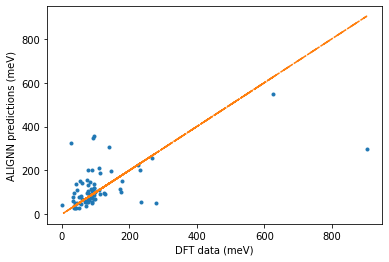

In [10]:
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')
plt.show()

In [11]:
# Run Trained Model to Predict Values for Compounds without Exfoliation Energy

import torch
from alignn.pretrained import get_multiple_predictions
from alignn.models.alignn import ALIGNN,ALIGNNConfig

if torch.cuda.is_available():
    device = torch.device("cuda") # might have to change to "cpu"


model = ALIGNN(ALIGNNConfig(name="alignn"))
model.load_state_dict(torch.load('ExfoEnOut/checkpoint_50.pt', map_location=device)["model"])
model.to(device)
model.eval()
atoms_array=[]

max_samples = 50
count = 1
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target == "na":
        atoms_array.append(atoms)
        count = count + 1
        if count == max_samples:
          break

get_multiple_predictions(atoms_array=atoms_array,model=model)
import pandas as pd
df=pd.read_json('pred_data.json')
df.sort_values('pred',ascending=False)

Using backend: pytorch


data range -9999 -9999


  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  r = torch.tensor(r).type(torch.get_default_dtype())
100%|██████████| 49/49 [00:01<00:00, 42.85it/s]


Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs


100%|██████████| 49/49 [00:00<00:00, 671.31it/s]


,id,atoms,pred
2,2,"{'lattice_mat': [[-1.833590720595598, 1.833590...",536.987610
17,17,"{'lattice_mat': [[7.709535704177289, 2.46207e-...",523.069946
24,24,"{'lattice_mat': [[4.084155317570781, -1.066825...",488.474487
48,48,"{'lattice_mat': [[4.086274992215878, 0.0, -0.6...",438.184509
45,45,"{'lattice_mat': [[-0.0, 4.326757913323647, 4.3...",431.418640
37,37,"{'lattice_mat': [[-0.0, 5.040771484524319, 5.0...",419.962097
19,19,"{'lattice_mat': [[6.850665464204784, -0.0, 0.0...",410.643097
33,33,"{'lattice_mat': [[0.0, 4.936437902689708, 4.93...",398.381226
41,41,"{'lattice_mat': [[0.0, 5.129874508851702, 5.12...",396.650482
7,7,"{'lattice_mat': [[4.284492173131309, 1.636192e...",370.480347


In [12]:
!pip freeze

absl-py==1.1.0
alabaster==0.7.12
albumentations==0.1.12
alignn==2022.1.25
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.2
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.7.7
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.7
certifi==2022.6.15
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dgl=